# Landslide Hazard Analysis Using SAR
In this notebook, you will learn how to generate a landslide density map  with an RTC-based change detection analysis.  You will create multi-temporal stacks of Sentinel-1 data using [XArray](https://docs.xarray.dev/en/stable/) and compare data from before and after an earthquake that triggered landslides.

In this tutorial, we will focus mapping landslides triggered by an $M_w$ 7.2 [earthquake in Haiti](https://en.wikipedia.org/wiki/2021_Haiti_earthquake) that occurred on August 14, 2021. The earthquake triggered widespread landslides across the southwestern part of the country, with  least 8,444 landslides triggered across a 2,700 $km^2$ (1,000 sq mi) area [(Zhang et al., 2021)](https://www.sciencedirect.com/science/article/abs/pii/S0169555X22003129).  Rapid response to the landslide and inventory of landslides was further hindered by the arrival of Tropical Storm Grace. The presence of consistent cloud coverage makes SAR data an ideal candidate to detect landslides in the aftermath, since SAR can penetrate through cloud cover.

This notebook will show you how to perform the time-series change detection as performed by [Handwerger et al., 2022](https://nhess.copernicus.org/articles/22/753/2022/). This process utilizes OnDemand RTC products from the Alaska Satellite Facility.

In this notebook, we will:
1. Use the HyP3 Python SDK to:
   - Request On Demand RTC products from ASF HyP3
   - Download the RTC products when they are done processing
<br></br>
2. And you will use [Xarray](https://docs.xarray.dev/en/stable/) and [Dask](https://docs.dask.org) to:
   - Download pre-processed data that we will use for the time series
   - Load data with Xarray
   - Group data pre-event and post-event and average both stacks
   - Perform a log difference between pre-event and post-even scenes
   - Plot a histogram of the log difference for a subset of the area
   - Reproduce the main landslide heatmap figure from Handwerger et al., 2022

---
**Note:** This notebook uses staged data to ensure that there is adequate time to step through the RTC analysis, and to discuss the analysis methods. All the code for producing the staged data is present in this notebook. If you would like to learn how to prep the data yourself outside of this workshop. All of the sections related to data prep that we will skip during this workshop will have an asterisk (*) next to their title.

## 0. Initial Setup

To run this notebook, you'll need to be in the `insar_analysis` conda environment within OpenSARLab.

Alternatively, you can set up your own environment by running these commands in your shell (you'll need to have [conda](https://docs.conda.io/projects/continuumio-conda/en/latest/user-guide/install/index.html) installed):
```shell
curl -OL https://raw.githubusercontent.com/ASFOpenSARlab/opensarlab-envs/main/Environment_Configs/insar_analysis_env.yml
conda env create -f insar_analysis_env.yml
```
Then launch this notebook from the new environment:
```shell
conda activate insar_analysis
jupyter lab igarss_landslide_heatmaps.ipynb
```

Once you have completed the setup for one of these two environments, you are ready to start working with the data.

## *1. Search for SLC images over Haiti in a defined time period
*You can skip this step if using the prepared data
The first step in data preparation is getting a list of scene names for the region of interest a year before the Haiti earthquake to a couple of weeks after the earthquake. Then, you will use the [`asf_search`](https://docs.asf.alaska.edu/asf_search/basics/) python module to find Sentinel-1 scenes that fit those parameters.

In [ ]:
from datetime import datetime

start_time = datetime.strptime('2020-08-01T23:59', '%Y-%m-%dT%H:%M')
end_time = datetime.strptime('2021-09-09T23:59', '%Y-%m-%dT%H:%M')
event_time = datetime.strptime('2021-08-14T00:00', '%Y-%m-%dT%H:%M')

import asf_search
scenes_to_submit = []
wkt = 'POLYGON((-74.6 18.0,-73.0 18.0,-73.0 18.8,-74.6 18.8, -74.6 18.0))'
results_descending = asf_search.geo_search(platform=[asf_search.PLATFORM.SENTINEL1], intersectsWith=wkt, processingLevel='SLC', start=start_time, end=end_time, relativeOrbit=142, frame=530)

This list of results can then be formated to a list of `sceneNames` to submit to HyP3.

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape

properties = [result.geojson()['properties'] for result in results_descending]
geometries = [shape(result.geojson()['geometry']) for result in results_descending]
gdf = gpd.GeoDataFrame(properties, geometry=geometries,crs='EPSG:4326').sort_values('startTime')
scenes_to_submit = list(gdf['sceneName'])
print(gdf.shape[0])

You can explore a map of the scene boundaries using the GeoDataFrame explorer:

In [ ]:
gdf.explore(style_kwds=dict(color='black', fill=False))

You can also visualize how many scenes were acquired before and after the earthquake:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plot_gdf = gdf[['sceneName', 'startTime']].copy()
plot_gdf['startTime'] = pd.to_datetime(plot_gdf['startTime'])
plot_gdf = plot_gdf.sort_values('startTime').reset_index()

f, ax = plt.subplots(1,1,figsize=(7,7))
ax.scatter(pd.to_datetime(plot_gdf['startTime']), plot_gdf.index, s=5)
ax.set(xlabel='Date', ylabel='Image Number')
ax.axvline(event_time, color='red')

## *2. Acquire Data using HyP3 SDK
*You can skip this step if using the prepared data

A major step towards working with SAR data at scale is learning how to request and download data programmatically. Accomplishing these tasks via code makes it much easier to request large quantities of data and to make similar requests in the future.
 To request the generation of Radiometrically Corrected Terrain (RTC) products from ASF, you can follow the general steps outlined in the cells below. For this example, you'll be requesting RTC products for the scenes you searched for in Step 1 to detect landslides in Haiti.

2.1 **Initial HyP3 SDK Setup**
If you don’t already have NASA Earthdata Login credentials, create a NASA Earthdata login profile. This will allow you connect to ASF HyP3 via the Python SDK. Since RTC processing can take some time, skip to Step 2.3 to download products that have already finished processsing.
Running the cell below will prompt you for your Earthdata username and password:

In [ ]:
import hyp3_sdk as sdk
hyp3 = sdk.HyP3(prompt=True)

2.2: **Submit a processing request (Skip this step during seminar)**
 Once you've logged into the HyP3 API, use the HyP3 SDK's [`submit_rtc_job`](https://hyp3-docs.asf.alaska.edu/using/sdk_api/#hyp3_sdk.hyp3.HyP3.submit_rtc_job) function to submit a processing request for all the scene names prepared in Step 1. You can use the `project_name` name argument to group sets of requests together under one name so that you can easily look them up later.

In [ ]:
print(f'Submitting {len(scenes_to_submit)} jobs')
rtc_jobs = sdk.Batch()
for scene in scenes_to_submit:
    rtc_jobs += hyp3.submit_rtc_job(granule=scene, resolution=20, name='IGARSS-HAITI-20m')

After submitting your request, ASF will process your data using HyP3, and output an InSAR product. You can monitor the status of your request by calling the [`watch`](https://hyp3-docs.asf.alaska.edu/using/sdk_api/#hyp3_sdk.hyp3.HyP3.watch) HyP3 SDK method.

In [ ]:
rtc_jobs = hyp3.watch(rtc_jobs)

2.3 **Download succeeded jobs and unzip**
Once processing is complete, the RTC job status will be updated to `SUCCEEDED` and data will be ready to download. You can download the data by searching for jobs using a project name and the `SUCCEEDED` status code. Here, we will search for jobs already finished with the job name `IGARSS_HAITI_20m`…

In [ ]:
rtc_jobs =  hyp3.find_jobs(name='IGARSS-HAITI-20m')

…then using the download_files method to download data to a designated directory.

In [ ]:
data_dir_path = 'haiti_rtcs'
succeeded_jobs = rtc_jobs.filter_jobs(succeeded=True, running=False, failed=False)
file_list = succeeded_jobs.download_files(location=data_dir_path)

The HyP3 SDK also includes an extract_zipped_product utility that you can use to unzip the files.

In [ ]:
from pathlib import Path
files = Path('haiti_rtcs').glob('*')
for file in files:
    sdk.util.extract_zipped_product(file, delete=False)

## *3. Crop all images to a common overlap
*You can skip this step if using the prepared data

You will need to subset all images to a common overlap to ensure all of your data are overlapping. For the purposes of this notebook, you will be using scenes with `VH` polarizations. Geotiffs are clipped using a [gdal](https://gdal.org/index.html) python binding, [osgeo](https://gdal.org/api/python_bindings.html), which is a straightforward option to utilize geospatial raster functions in your `insar_analysis` conda environment.

In [ ]:
from pathlib import Path
from typing import List, Union


def get_common_overlap(file_list: List[Union[str, Path]]) -> List[float]:
    """Get the common overlap of  a list of GeoTIFF files
    
    Arg:
        file_list: a list of GeoTIFF files
    
    Returns:
         [ulx, uly, lrx, lry], the upper-left x, upper-left y, lower-right x, and lower-right y
         corner coordinates of the common overlap
    """
    
    corners = [gdal.Info(str(dem), format='json')['cornerCoordinates'] for dem in file_list]

    ulx = max(corner['upperLeft'][0] for corner in corners)
    uly = min(corner['upperLeft'][1] for corner in corners)
    lrx = min(corner['lowerRight'][0] for corner in corners)
    lry = max(corner['lowerRight'][1] for corner in corners)
    return [ulx, uly, lrx, lry]

In [ ]:
from pathlib import Path
from typing import List, Union

def clip_hyp3_products_to_common_overlap(data_dir: Union[str, Path], overlap: List[float]) -> None:
    """Clip all GeoTIFF files to their common overlap
    
    Args:
        data_dir:
            directory containing the GeoTIFF files to clip
        overlap:
            a list of the upper-left x, upper-left y, lower-right-x, and lower-tight y
            corner coordinates of the common overlap
    Returns: None
    """

    
    files_for_mintpy = ['_VH.tif']

    for extension in files_for_mintpy:

        for file in data_dir.rglob(f'*{extension}'):

            dst_file = file.parent / f'{file.stem}_clipped{file.suffix}'

            gdal.Translate(destName=str(dst_file), srcDS=str(file), projWin=overlap)

In [ ]:
data_dir = Path('haiti_rtcs')
files = list(data_dir.glob('**/*_VH.tif'))
overlap = get_common_overlap(files)
clip_hyp3_products_to_common_overlap(data_dir, overlap)

## *4. Prep data for later use
*You can skip this step if using the prepared data

This step will create the staged data archive that we will download in the next step. This step has no effect on the data we're using, but it's necessary for packaging the data into a zip archive.

In [ ]:
from pathlib import Path
import shutil

save_dir = Path('haiti_rtcs_staged')
save_dir.mkdir(exist_ok=True)
file_paths = Path('haiti_rtcs').glob('*/*_VH_clipped.tif')

output = [shutil.copy(file, save_dir) for file in file_paths]

In [ ]:
shutil.make_archive('haiti_rtcs_staged', 'zip', save_dir)

## 5. Download and extract staged data
If working with the staged data, this will be the section where you start. In this section we'll download the staged data from Amazon S3.

In [ ]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config

s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
s3_client.download_file('ffwilliams2-shenanigans', 'igarss_2023/haiti_rtcs_staged.zip', 'haiti_rtcs_staged.zip')

In [ ]:
import zipfile

with zipfile.ZipFile('haiti_rtcs_staged.zip', 'r') as zip_ref:
    zip_ref.extractall('haiti_rtcs')

## 6. Download and prep auxillary data

In addition to our RTC data, we'll also need some additional data. In particular we'll a DEM, a DEM-based slope raster, and a Sentinel-2 optical image to compare our data to. 

6.1 **DEM-based data**
First, we'll download the data [GLO30 DEM](https://spacedata.copernicus.eu/collections/copernicus-digital-elevation-model) data for Haiti. The European Space Administration provides this DEM, and it is the best freely-available global DEM currently available. We'll download it using the `dem_stitcher` Python library which we'll install below:

In [ ]:
!python -m pip install dem_stitcher

In [1]:
from pathlib import Path

from osgeo import gdal
import rasterio
from dem_stitcher import stitch_dem

data_dir_path = Path('haiti_rtcs')
file_paths = list(Path('haiti_rtcs').glob('*_VH_clipped.tif'))

dem_file = data_dir_path / 'DEM.tif'
bounds = [-74.6, 18.0, -73.0, 18.8]
X, p = stitch_dem(bounds,
                  dem_name='glo_30',  # Global Copernicus 30 meter resolution DEM
                  dst_ellipsoidal_height=False,
                  dst_area_or_point='Point')


with rasterio.open(dem_file, 'w', **p) as ds:
   ds.write(X, 1)
   ds.update_tags(AREA_OR_POINT='Point')
    
with rasterio.open(file_paths[0]) as ds:
    epsg = ds.crs.to_epsg()
    # bounds = ds.bounds
    xres = ds.transform[0]
    yres = ds.transform[4]

bounds = [554420, 1990281, 691768, 2066380]
    
ds = gdal.Warp(str(dem_file), str(dem_file), dstSRS=f'EPSG:{epsg}', dstNodata=0,
        outputBounds=bounds, xRes=xres, yRes=yres, targetAlignedPixels=True, resampleAlg='nearest', format='GTiff')
del ds

Reading glo_30 Datasets: 100%|██████████| 2/2 [00:04<00:00,  2.32s/it]


Now that our DEM is downloaded and in the same coordinate reference system as our RTC data, we'll create a slope raster using GDAL.

In [2]:
import os
from osgeo import gdal

process_dem_file = data_dir_path / 'slope.tif'
tmp_file = data_dir_path / 'tmp.tif'
gdal.DEMProcessing(destName=str(tmp_file), srcDS=str(dem_file), processing='slope', format='GTiff', slopeFormat='degree')
gdal.Translate(destName=str(process_dem_file), srcDS=str(tmp_file), format='GTiff')
os.remove(tmp_file)

6.2 **Sentinel-2 data** To have something to compare our analysis to, we'll also download some optical data collected by the Sentinel-2 satellite just after the Haiti earthquake. This data is available on the [AWS Open Data Registry](https://registry.opendata.aws/sentinel-2/). If you have an AWS set up, you can use the commands below to download the data directly.

```bash
aws s3 cp --request-payer requester s3://sentinel-s2-l2a/tiles/18/Q/WF/2021/9/8/0/R20m/TCI.jp2 s2_haiti_left.jp2
aws s3 cp --request-payer requester s3://sentinel-s2-l2a/tiles/18/Q/XF/2021/9/8/0/R20m/TCI.jp2 s2_haiti_right.jp2
```

For this workshop, you will NOT have an AWS profile set up, so we've staged some data in an open AWS S3 bucket for you to download:

In [3]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config

s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
s3_client.download_file('ffwilliams2-shenanigans', 'igarss_2023/s2_haiti_left.jp2', 'haiti_rtcs/s2_haiti_left.jp2')
s3_client.download_file('ffwilliams2-shenanigans', 'igarss_2023/s2_haiti_right.jp2', 'haiti_rtcs/s2_haiti_right.jp2')

Then similar to our DEM prep, we'll merge the data we downloaded and transform it to the bounds and coordinate reference system of our RTC data.

In [4]:
from pathlib import Path

import rasterio
from osgeo import gdal


file_paths = list(Path('haiti_rtcs').glob('*_VH_clipped.tif'))

with rasterio.open(file_paths[0]) as ds:
    epsg = ds.crs.to_epsg()
    # bounds = ds.bounds
    xres = ds.transform[0]
    yres = ds.transform[4]

bounds = [554420, 1990281, 691768, 2066380]

infiles = ['haiti_rtcs/s2_haiti_left.jp2', 'haiti_rtcs/s2_haiti_right.jp2']
outfile = 'haiti_rtcs/s2_haiti.tif'
ds = gdal.Warp(outfile, infiles, dstSRS=f'EPSG:{epsg}', dstNodata=0, 
          outputBounds=bounds, xRes=xres, yRes=yres, targetAlignedPixels=True, resampleAlg='nearest', format='GTiff')
del ds

Now we have all the data we need!

## 7. Load the geotiffs into Xarray with datetime stamps for each image
After all of your data orginization and preparation, it is finally time to load data with [Xarray](https://docs.xarray.dev/en/stable/getting-started-guide/why-xarray.html), a python module that simplifies working with mutli-dimensional arrays. This will be an excellent tool for working of a stack of raster data, especially since each raster can be indexed by its acquisition date, which we will call the `time` dimension of the stack.
Note that Xarray integrates [Dask](https://www.dask.org/) to support [parallel computing](https://docs.xarray.dev/en/stable/user-guide/dask.html), so you will use an argument called `chunks` to instruct Dask on how to divide arrays. This also means that computation will be delayed, so that you will provide it instructions on what to do and later call a `compute` function that will perform the analysis.

In [5]:
import xarray as xr
import os
from pathlib import Path
from datetime import datetime

def preprocess(da_orig, file_type: str='vh'):
    '''function that should return an xarray object with time dimension and associated metadata given a path to a single RTC scene, if its dualpol will have multiple bands, currently just as 2 data arrays but could merge.
    goal would be to apply this a list of directories for different RTC products, return cube along time dimension - I think?
    - for concatenating, would need to check footprints and only take products with the same footprint, or subset them all to a common AOI? '''
    da = da_orig.copy()
    da = da.rename({'band_data': file_type}).squeeze()
    fname = os.path.basename(da_orig['band_data'].encoding['source'])
    time = datetime.strptime(fname[7:22], '%Y%m%dT%H%M%S')
    da = da.assign_coords({'time': time})
    da = da.expand_dims('time')
    da = da.drop_duplicates(dim=['x', 'y'])

    return da

In [6]:
file_paths = list(Path('haiti_rtcs').glob('*_VH_clipped.tif'))
rtc_vh = xr.open_mfdataset(paths = file_paths, preprocess = preprocess, chunks = 'auto', engine='rasterio', data_vars='minimal', coords='minimal', concat_dim='time', combine='nested', parallel=True)

Now that your data are loaded in, you can run the next cell to get a visual representation of the stack:

In [7]:
rtc_vh['vh']

<xarray.DataArray 'vh' (time: 34, y: 11047, x: 14119)>
dask.array<concatenate, shape=(34, 11047, 14119), dtype=float32, chunksize=(1, 5122, 6550), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 5.058e+05 5.058e+05 ... 7.882e+05 7.882e+05
  * y            (y) float64 2.179e+06 2.179e+06 ... 1.958e+06 1.958e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2021-05-23T10:47:31 ... 2020-10-07T10:...
Attributes:
    AREA_OR_POINT:     Point
    TIFFTAG_DATETIME:  2023:07:11 19:06:19
    TIFFTAG_SOFTWARE:  Created with GAMMA Software www.gamma-rs.ch data2geoti...

Notice how the array is a bit larger than 19 GB? Using Xarray's and Dask's chunked computing capabilities allows us to work with datasets that are much larger than we can fit in memory!

Since clipped data are still larger than the area of interest of where the landslides were triggered, you can clip the stacked rasters to the same `x` and `y` slices. This means only the pixels in the AOI will be included in computation.

In [8]:
x_slice = slice(554420, 691768)
y_slice = slice(2066380, 1990281)
rtc_vh = rtc_vh.sel(x=x_slice, y=y_slice)

Now, you can check that the slicing was successful and has the new dimensions:

In [9]:
rtc_vh['vh']

<xarray.DataArray 'vh' (time: 34, y: 3805, x: 6867)>
dask.array<getitem, shape=(34, 3805, 6867), dtype=float32, chunksize=(1, 3805, 4120), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 5.544e+05 5.544e+05 ... 6.917e+05 6.918e+05
  * y            (y) float64 2.066e+06 2.066e+06 2.066e+06 ... 1.99e+06 1.99e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2021-05-23T10:47:31 ... 2020-10-07T10:...
Attributes:
    AREA_OR_POINT:     Point
    TIFFTAG_DATETIME:  2023:07:11 19:06:19
    TIFFTAG_SOFTWARE:  Created with GAMMA Software www.gamma-rs.ch data2geoti...

## 8. Convert RTCs to decibel scale and remove low-valued zones
Next, we'll convert the RTC products from the default output of Power to the decibel (dB) scale. The dB scale is a good scale to use for looking for changes in the landscape, due to its logarithmic scale. Once converted, you will want to mask pixels that are low-values under -20 dB to remove some noise from the dataset.

In [10]:
%%time
import numpy as np

rtc_db = 10 * np.log10(rtc_vh['vh'])
rtc_db = rtc_db.where(rtc_db > -20)

CPU times: user 11.2 ms, sys: 0 ns, total: 11.2 ms
Wall time: 9.47 ms


Notice how that cell completed quickly even though we performed a complex calculation on Gigabytes of data? That's because Xarray and Dask delay performing calculations until we need to use the underlying data. This is useful when performing several operations in a row (like we will) because we'll only need to read the data once.

## 9. Create a temporal average for both pre and post
You can now group the RTC stack by scenes acquired before and after the 2021 earthquake that triggered widespread landslides in Haiti. Using the Xarray function [GroupBy](https://docs.xarray.dev/en/stable/user-guide/groupby.html), you can create bins and index according to the event time. Then, you can take the median of the pre-event and post-event stacks. 

In [11]:
%%time
from datetime import datetime

start_time = datetime.strptime('2020-08-01T23:59', '%Y-%m-%dT%H:%M')
end_time = datetime.strptime('2021-09-09T23:59', '%Y-%m-%dT%H:%M')
event_time = datetime.strptime('2021-08-14T00:00', '%Y-%m-%dT%H:%M')

date_bins = [start_time, event_time, end_time]
date_bin_labels = ['preevent', 'postevent']

rtc_db_grouped = rtc_db.groupby_bins('time', date_bins, labels=date_bin_labels)
mean_db = rtc_db_grouped.median(dim='time')

CPU times: user 25.6 ms, sys: 118 µs, total: 25.7 ms
Wall time: 23.4 ms


Once again, notice how fast that cell completed because we are delaying computation.

The resulting groups of data appear now as 2 datasets in the stack: 

In [12]:
mean_db

<xarray.DataArray 'vh' (time_bins: 2, y: 3805, x: 6867)>
dask.array<stack, shape=(2, 3805, 6867), dtype=float32, chunksize=(1, 1095, 988), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 5.544e+05 5.544e+05 ... 6.917e+05 6.918e+05
  * y            (y) float64 2.066e+06 2.066e+06 2.066e+06 ... 1.99e+06 1.99e+06
    spatial_ref  int64 0
  * time_bins    (time_bins) object 'preevent' 'postevent'

## 10. Mask out areas with slopes less than 5%

In addition to temporally averaging the data to reduce noise, we're also going to exclude areas from the analysis if we are confident that landslides can't occur there. In this case we'll use the heuristic that *landslides only occur in steep areas and not on flat ground* to remove some areas. We'll do this by using a DEM to calculate the local slope of our study area. Then we'll mask out all areas that have a less than a 5 degree slope.

Next, let's read in the data using Xarray and create the < 5 degree slope mask.

In [13]:
import xarray as xr

# x_slice = slice(554420, 691768)
# y_slice = slice(2066380, 1990281)
data_dir_path = Path('haiti_rtcs')
process_dem_file = data_dir_path / 'slope.tif'
slope = xr.open_dataset(process_dem_file, engine='rasterio').squeeze()
# slope = slope.sel(x=x_slice, y=y_slice)
slope_mask = slope['band_data'] > 5

Finally, we'll apply the mask to our RTC data.

In [15]:
mean_db = mean_db.where(slope_mask)

## 11. Perform a log difference of the two resulting images.

It's finally time to create the log difference image by subtracting the dB scale pre-earthquake median map from the dB scale post-earthquake median map. Notice how we're calling `compute` on the resulting Xarray object. This tells Xarray to finally perform all of the computations that we've been providing it. This cell should take about two minutes to complete.

In [16]:
%%time

from dask.distributed import Client

client = Client(n_workers=4)
log_diff =  mean_db[0] - mean_db[1]
log_diff = log_diff.compute(client=client)
client.close()

2023-07-13 18:43:24,435 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.26 GiB -- Worker memory limit: 4.00 GiB
2023-07-13 18:43:24,442 - distributed.worker.memory - WARNING - Worker is at 75% memory usage. Resuming worker. Process memory: 3.00 GiB -- Worker memory limit: 4.00 GiB
/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
2023-07-13 18:43:29,522 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.88 GiB -- Worker memory limit: 4.00 GiB
2023-07-13 18:43:30,709 - distributed.worker.memory - WARNING - Unmanaged memory use is high.

CPU times: user 8.57 s, sys: 1.41 s, total: 9.98 s
Wall time: 54.1 s


Let's look at the results! Areas with landslide activity should show up as clusters of large positive values.

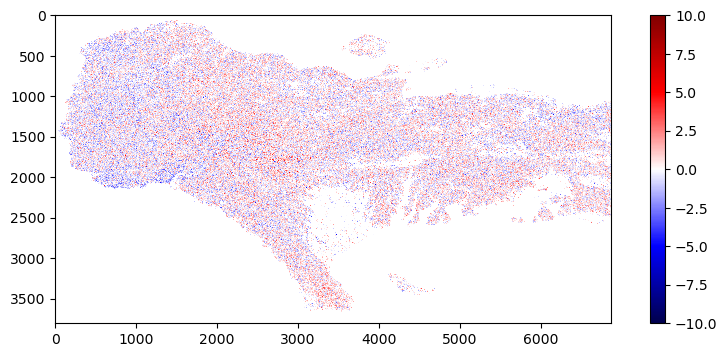

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt

f, ax = plt.subplots(1,1, figsize=(10,4))
plot = ax.imshow(log_diff, cmap='seismic', interpolation='none', vmin=-10, vmax=10)
f.colorbar(plot)

We can also take a close-up look at smaller regions. In the graph below we look at an area that has some landslide activity in the top of the image. The histogram on the right show the distribution of log difference values in this region. As you can see, this distribution looks approximately normal, which means that it may be hard to select classification values when we try to identify discrete landslides.

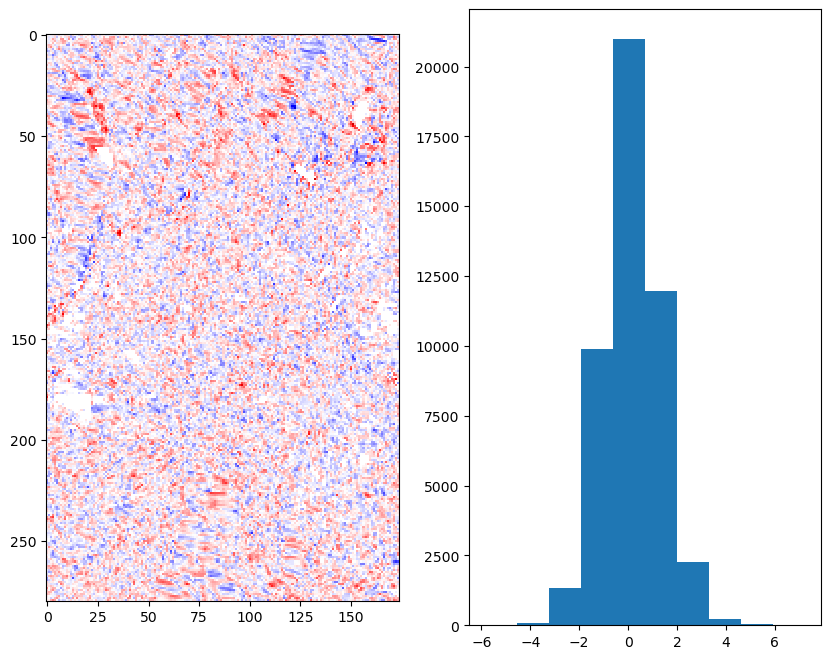

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt

x_lim = slice(598507,601974)
y_lim = slice(2030321,2024714)
roi = log_diff.sel(x=x_lim, y=y_lim)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8))
plot = ax1.imshow(roi, cmap='seismic', interpolation='none', vmin=-10, vmax=10)
hist = ax2.hist(roi.values.flatten())

## 12. Threshold the log difference image to identify landslides
 As mentioned previously, landslides remove vegetation from the slopes, which will correspond to positive values, since there is an increase in post-event backscatter intensity. By setting a threshold intensity change for landslide areas, pixels with significant change will be included in your final map. First, re-plot the log difference pixels for a reference:

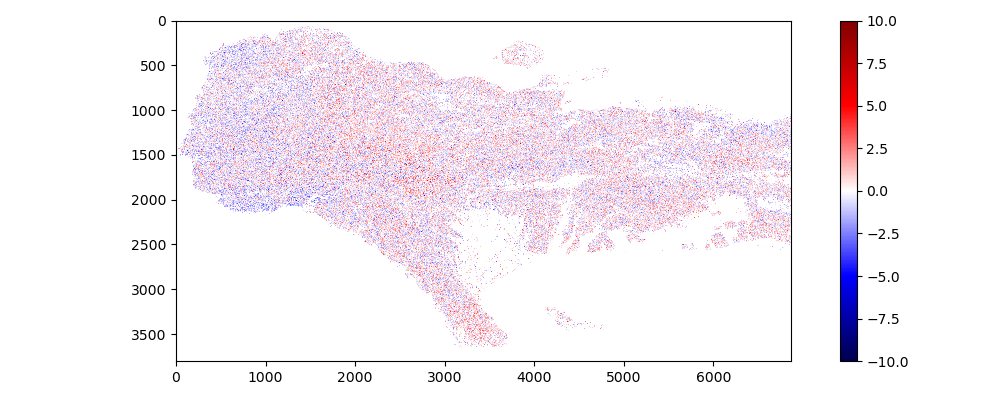

In [19]:
%matplotlib widget

import matplotlib.pyplot as plt
f, ax = plt.subplots(1,1, figsize=(10,4))
log_ratio_plot = ax.imshow(log_diff, cmap='seismic', interpolation='none', vmin=-10, vmax=10)
f.colorbar(log_ratio_plot)
plt.tight_layout()

Then plot which pixels exceed the landslide threshold:

In [28]:
np.unique(plot_image)

array([0., 1.])

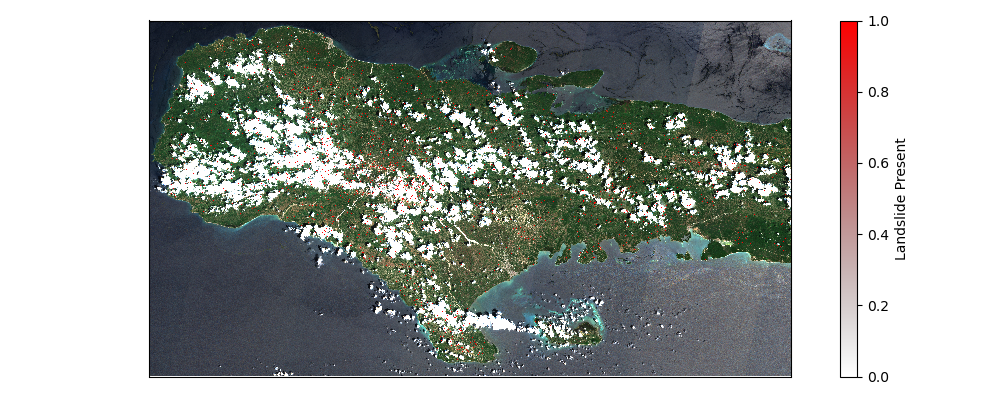

In [31]:
%matplotlib widget

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LinearSegmentedColormap

threshold = 2.5
thresholded_image = log_diff > threshold

colors = [(0, 0, 0, 0), (1, 0, 0, 1)]
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

f, ax = plt.subplots(1,1, figsize=(10,4))
base_image = ax.imshow(mpimg.imread('haiti_rtcs/s2_haiti.tif'), interpolation='none')
landslide_plot = ax.imshow(thresholded_image, cmap=cmap, interpolation='none')
settings = ax.set(xticks=[], yticks=[])
f.colorbar(landslide_plot, label='Landslide Present')
plt.tight_layout()

For this map, we used a threshold of 2.5 Db, but this may not be the *best* threshold value. As discussed in Handwerger et al., 2022 selecting an appropriate threshold value is a difficult but important process. Like Handwerger et al., we're using an iterative approach to find the best value possible. Do you think you can find a better value than 2.5 Db?

## 13. Create the final density plot
While the previous map provides an idea of what the spatial distribution of landslides is, we can understand the spatial distribution even better by plotting it as a density map. Warmer colors indicate there are more landslides, whereas green represent regions with fewer pixels exceeding the threshold. You can also compare the epicenter of the August 14 earthquake, represented by the black star, with the distribution of landslides. 
Note how the epicenter is not in the centered on the area with the darkest red. Rather, these landslides were triggered remotely by the earthquake. 

First we'll create the landslide density data

In [32]:
%%time
import numpy as np
from scipy.stats import gaussian_kde
from scipy.ndimage import zoom

thresholded_ndarray = thresholded_image.values.astype(int)
thresholded_ndarray = np.round(zoom(thresholded_ndarray, 0.125)).astype(int)

nonzero_indices = np.transpose(np.nonzero(thresholded_ndarray))
kde = gaussian_kde(nonzero_indices.T, bw_method=0.2)

x_indices, y_indices = np.indices(thresholded_ndarray.shape)

x_flattened = x_indices.flatten()
y_flattened = y_indices.flatten()

indices = np.vstack((x_flattened, y_flattened))
density_array = kde(indices)
density_array = density_array.reshape(thresholded_ndarray.shape)
density_array[density_array < 0.0000015] = np.nan

CPU times: user 17.2 s, sys: 800 ms, total: 18 s
Wall time: 17.6 s


Next, we'll resample our DEM into the same resolution as the density data so we can use it as a basemap.

In [33]:
import xarray
from scipy.ndimage import zoom

x_slice = slice(554420, 691768)
y_slice = slice(2066380, 1990281)
dem = xarray.open_dataset('haiti_rtcs/DEM.tif', engine='rasterio').squeeze()
dem = dem.sel(x=x_slice, y=y_slice)

dem_ndarray = dem['band_data'].values
dem_ndarray[np.isnan(dem_ndarray)] = 0
dem_ndarray = zoom(dem_ndarray, 0.125)
dem_ndarray[dem_ndarray <= 5] = np.nan

Now let's make the final plot.

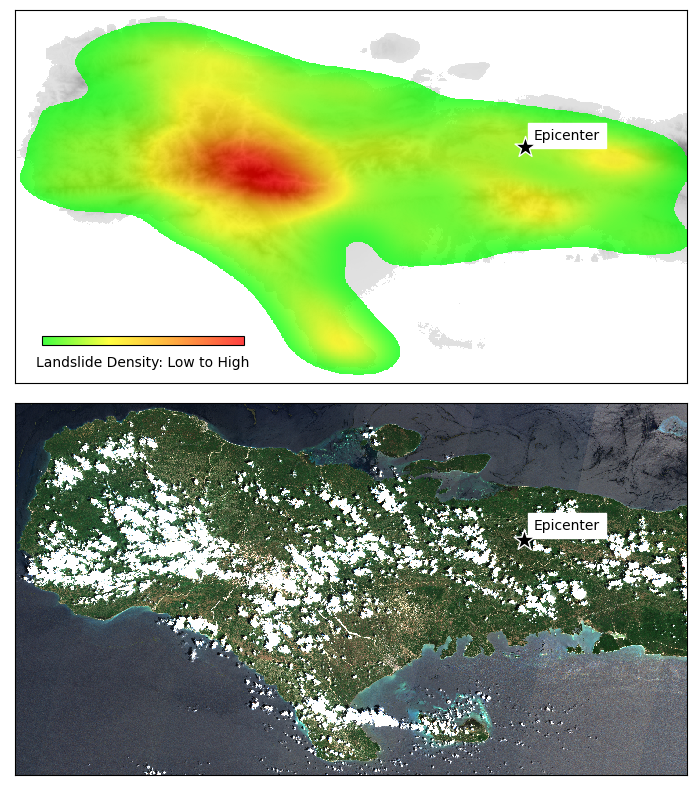

In [34]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg

colors = [(0, 'lime'),
          (0.33, 'yellow'),
          (0.6, 'orange'),
          (1, 'red')]
cmap = LinearSegmentedColormap.from_list('green_orange_red', colors)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
dem_plot = ax1.imshow(dem_ndarray, cmap='Greys', interpolation='none', vmin=-500, vmax=2000)
density_plot = ax1.imshow(density_array, cmap=cmap, alpha=0.75, interpolation='none')
ax1.annotate('Epicenter', size=10, xy=(662, 165), backgroundcolor='white', zorder=0)
ax1.scatter(650, 175, s=250, marker='*', color='black', edgecolor='white')
ax1.set(xticks=[], yticks=[])

base_image = ax2.imshow(mpimg.imread('haiti_rtcs/s2_haiti.tif'), interpolation='none')
ax2.scatter(5200, 1400, s=250, marker='*', color='black', edgecolor='white')
ax2.annotate('Epicenter', size=10, xy=(5300, 1300), backgroundcolor='white', zorder=0)
ax2.set(xticks=[], yticks=[])
                   
cax = ax1.inset_axes([0.04, 0.1, 0.3, 0.025])
cbar = f.colorbar(density_plot, ax=ax1, cax=cax, label='Landslide Density: Low to High', orientation='horizontal', ticks=[])

plt.tight_layout()

Very similar to Handwerger et al.'s landslide density plot!

<img src="images/handwerger_et_al_figure.png" alt="Handwerger et al. Landslide Density Plot" style="width: 700px;"/>